In [1]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/xupeng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
cd ..

/home/xupeng/projects/membrane


In [4]:
ls data/train/mip1/trainingpath_400/Train

image_0.png    image_236.png  image_372.png  mask_16.png   mask_305.png
image_100.png  image_237.png  image_373.png  mask_170.png  mask_306.png
image_101.png  image_238.png  image_374.png  mask_171.png  mask_307.png
image_102.png  image_239.png  image_375.png  mask_172.png  mask_308.png
image_103.png  image_23.png   image_37.png   mask_173.png  mask_309.png
image_104.png  image_240.png  image_38.png   mask_174.png  mask_30.png
image_105.png  image_241.png  image_39.png   mask_175.png  mask_310.png
image_106.png  image_242.png  image_3.png    mask_176.png  mask_311.png
image_107.png  image_243.png  image_40.png   mask_177.png  mask_312.png
image_108.png  image_244.png  image_41.png   mask_178.png  mask_313.png
image_109.png  image_245.png  image_42.png   mask_179.png  mask_314.png
image_10.png   image_246.png  image_43.png   mask_17.png   mask_315.png
image_110.png  image_247.png  image_44.png   mask_180.png  mask_316.png
image_111.png  image_248.png  image_45.png   mask_181.png  mask_3

In [5]:
imread('data/train/mip1/trainingpath_400/Train/image_0.png').shape

(512, 512)

In [8]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_context(contexts[0])
sns.set_style(styles[0])

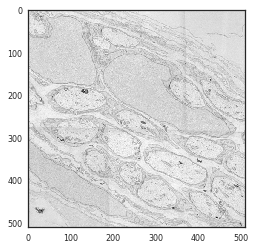

In [37]:
imshow(imread('data/train/mip1/trainingpath_400/Train/image_0.png'),cmap='gray')

In [60]:
import numpy as np
import time
import random
import math
from scipy.ndimage.interpolation import map_coordinates, zoom
import numbers
from skimage.draw import line
from scipy.ndimage.measurements import label
from scipy.ndimage.morphology import binary_dilation

'''
simple augmentation: 
- train: random select method, 1 to 1
- test: produce 16 from each sample, 
- test: reverse to one and calculate mean

intensity augmentation:
- train: mode: mix
'''

# produce 16 binary arr
binaryarr = np.zeros([16, 4]).astype('int')
for t in range(16):
    binaryarr[t] = np.concatenate((np.repeat(0, 4-len(bin(t)[2:])), np.array(
        [bin(t)[2:][i] for i in range(len(bin(t)[2:]))]).astype('int')))


def augmentsimple(data, rule):
    assert np.size(rule) == 4 and data.ndim == 3
    # z reflection.
    if rule[0]:
        data = data[::-1, :, :]
    # x reflection.
    if rule[1]:
        data = data[:, :, ::-1]
    # y reflection.
    if rule[2]:
        data = data[:, ::-1, :]
    # Transpose in xy.
    if rule[3]:
        data = data.transpose(0, 2, 1)
    return data


def produce_simple_16_sample(imgs, imgshape):
    '''
    imgs: 24*256*256 -> 16*24*256*256
    '''
    assert imgs.ndim == 3
    augmentsimplearr = np.ndarray(
        [16, imgshape[0], imgshape[1], imgshape[2]])
    for i in range(16):
        augmentsimplearr[i] = augmentsimple(imgs, binaryarr[i])
    return augmentsimplearr


def produce_simple_train_sample(imgs, rule):
    '''
    imgs: 24*256*256 -> 16*24*256*256
    '''
    assert imgs.ndim == 3
    return augmentsimple(imgs, rule)


class simpleaug_test_produce():
    def __init__(self, model_io_size=[24, 256, 256]):
        self.model_io_size = model_io_size

    def __call__(self, imgs):
        return produce_simple_16_sample(imgs, self.model_io_size)


class simpleaug_train_produce():
    def __init__(self, model_io_size=[24, 256, 256]):
        self.model_io_size = model_io_size

    def __call__(self, imgs, mask):
        #print (self.rule)
        rule = np.random.randint(2, size=4)
        imgs_aug = produce_simple_train_sample(imgs, rule)
        mask_aug = produce_simple_train_sample(mask, rule)
        return imgs_aug, mask_aug


# class simpleaug_train_produce():
#     def __init__(self, model_io_size=[24, 256, 256]):
#         self.rule = np.random.randint(2, size=4)

#     def __call__(self, imgs, mask):
#         #print (self.rule)
#         imgs_aug = produce_simple_train_sample(imgs, self.rule)
#         mask_aug = produce_simple_train_sample(mask, self.rule)
#         return imgs_aug, mask_aug


class simpleaug_test_reverse():
    def __init__(self, model_io_size=[24, 256, 256]):
        self.model_io_size = model_io_size

    def augmentsimplereverse(self,data, rule):
        assert np.size(rule) == 4 and data.ndim == 3
        # z reflection.
        if rule[3]:
            data = data.transpose(0, 2, 1)
        if rule[2]:
            data = data[:, ::-1, :]
        if rule[1]:
            data = data[:, :, ::-1]
        if rule[0]:
            data = data[::-1, :, :]
        return data

    def reverse_and_mean(self,imgs, imgshape):
        '''
        imgs: 16*24*256*256 ->24*256*256
        '''
        assert imgs.ndim == 4
        reversedsimplearr = np.ndarray(
            [16, imgshape[0], imgshape[1], imgshape[2]])
        for i in range(16):
            reversedsimplearr[i] = self.augmentsimplereverse(imgs[i], binaryarr[i])
        return np.mean(reversedsimplearr, axis=0)

    def __call__(self, imgs):
        return self.reverse_and_mean(imgs, self.model_io_size)


class IntensityAugment():
    def __init__(self,  mode='mix', skip_ratio=0.3, CONTRAST_FACTOR=0.3, BRIGHTNESS_FACTOR=0.3):
        """
        Initialize parameters.
        Args:
            mode: 2D, 3D, or mix
        """
        assert mode == '3D' or mode == '2D' or mode == 'mix'
        self.mode = mode
        self.ratio = skip_ratio
        self.CONTRAST_FACTOR = CONTRAST_FACTOR
        self.BRIGHTNESS_FACTOR = BRIGHTNESS_FACTOR

    def augment(self, imgs):
        skiprand = np.random.rand()
        if skiprand > self.ratio:
            if self.mode == 'mix':
                threshold = 1-(1-self.ratio)/2
                mode_ = '3D' if skiprand > threshold else '2D' 
            else:
                mode_ = self.mode   
            if mode_ == '2D':
                imgs = self.augment2D(imgs)
            elif mode_ == '3D':
                imgs = self.augment3D(imgs)
            return imgs
        else:
            return imgs

    def augment2D(self, imgs):
        for z in range(imgs.shape[-3]):
            img = imgs[z, :, :]
            img *= 1 + (np.random.rand() - 0.5)*self.CONTRAST_FACTOR
            img += (np.random.rand() - 0.5)*self.BRIGHTNESS_FACTOR
            img = np.clip(img, 0, 1)
            img **= 2.0**(np.random.rand()*2 - 1)
            imgs[z, :, :] = img
        return imgs

    def augment3D(self, imgs):
        imgs *= 1 + (np.random.rand() - 0.5)*self.CONTRAST_FACTOR
        imgs += (np.random.rand() - 0.5)*self.BRIGHTNESS_FACTOR
        imgs = np.clip(imgs, 0, 1)
        imgs **= 2.0**(np.random.rand()*2 - 1)
        return imgs


def create_identity_transformation(shape, subsample=1):

    dims = len(shape)
    subsample_shape = tuple(max(1, int(s/subsample)) for s in shape)
    step_width = tuple(float(shape[d]-1)/(subsample_shape[d]-1)
                       if subsample_shape[d] > 1 else 1 for d in range(dims))

    axis_ranges = (
        np.arange(subsample_shape[d], dtype=np.float32)*step_width[d]
        for d in range(dims)
    )
    return np.array(np.meshgrid(*axis_ranges, indexing='ij'), dtype=np.float32)


def upscale_transformation(transformation, output_shape, interpolate_order=1):

    input_shape = transformation.shape[1:]

    # print("Upscaling control points")
    # print("\tfrom               : " + str(input_shape))
    # print("\tto                 : " + str(output_shape))
    # print("\tinterpolation order: " + str(interpolate_order))

    dims = len(output_shape)
    scale = tuple(float(s)/c for s, c in zip(output_shape, input_shape))

    #start = time.time()
    scaled = np.zeros((dims,)+output_shape, dtype=np.float32)
    for d in range(dims):
        zoom(transformation[d], zoom=scale,
             output=scaled[d], order=interpolate_order)
    # print("\tupsampled in " + str(time.time() - start) + "s")

    return scaled


def create_elastic_transformation(shape, control_point_spacing=100, jitter_sigma=10.0, subsample=1):

    dims = len(shape)
    subsample_shape = tuple(max(1, int(s/subsample)) for s in shape)

    try:
        spacing = tuple((d for d in control_point_spacing))
    except:
        spacing = (control_point_spacing,)*dims
    try:
        sigmas = [s for s in jitter_sigma]
    except:
        sigmas = [jitter_sigma]*dims

    control_points = tuple(
        max(1, int(round(float(shape[d])/spacing[d])))
        for d in range(len(shape))
    )

    # print("Creating elastic transformation with:")
    # print("\tcontrol points per axis: " + str(control_points))
    # print("\taxis jitter sigmas     : " + str(sigmas))

    # jitter control points
    control_point_offsets = np.zeros(
        (dims,) + control_points, dtype=np.float32)
    for d in range(dims):
        if sigmas[d] > 0:
            control_point_offsets[d] = np.random.normal(
                scale=sigmas[d], size=control_points)

    return upscale_transformation(control_point_offsets, subsample_shape, interpolate_order=3)


def rotate(point, angle):

    res = np.array(point)
    res[0] = math.sin(angle)*point[1] + math.cos(angle)*point[0]
    res[1] = -math.sin(angle)*point[0] + math.cos(angle)*point[1]

    return res


def create_rotation_transformation(shape, angle, subsample=1):

    dims = len(shape)
    subsample_shape = tuple(max(1, int(s/subsample)) for s in shape)
    control_points = (2,)*dims

    # map control points to world coordinates
    control_point_scaling_factor = tuple(float(s-1) for s in shape)

    # rotate control points
    center = np.array([0.5*(d-1) for d in shape])

    # print("Creating rotation transformation with:")
    # print("\tangle : " + str(angle))
    # print("\tcenter: " + str(center))

    control_point_offsets = np.zeros(
        (dims,) + control_points, dtype=np.float32)
    for control_point in np.ndindex(control_points):

        point = np.array(control_point)*control_point_scaling_factor
        center_offset = np.array(
            [p-c for c, p in zip(center, point)], dtype=np.float32)
        rotated_offset = np.array(center_offset)
        rotated_offset[-2:] = rotate(center_offset[-2:], angle)
        displacement = rotated_offset - center_offset
        control_point_offsets[(slice(None),) + control_point] += displacement

    return upscale_transformation(control_point_offsets, subsample_shape)


def random_offset(max_misalign):

    return Coordinate((0,) + tuple(max_misalign - random.randint(0, 2*int(max_misalign)) for d in range(2)))


def misalign(transformation, prob_slip, prob_shift, max_misalign):
    num_sections = transformation[0].shape[0]
    print (num_sections)
    shifts = [Coordinate((0, 0, 0))]*num_sections
    for z in range(num_sections):
        r = random.random()
        #print (r)
        if r <= prob_slip:
            shifts[z] = random_offset(max_misalign)
            #print ('shifts '+str(shifts[z]))
        elif r <= prob_slip + prob_shift:
            offset = random_offset(max_misalign)
            for zp in range(z, num_sections):
                shifts[zp] += offset
                #print ('shiftzp '+str(shifts[zp]))
    #print ("misaligning sections with " + str(shifts))

    for z in range(num_sections):
        transformation[1][z, :, :] += shifts[z][1]
        transformation[2][z, :, :] += shifts[z][2]
    return transformation


class ElasticAugment():
    '''Elasticly deform a batch. Requests larger batches upstream to avoid data 
    loss due to rotation and jitter.
    Args:
        control_point_spacing (``tuple`` of ``int``):
            Distance between control points for the elastic deformation, in
            voxels per dimension.
        jitter_sigma (``tuple`` of ``float``):
            Standard deviation of control point jitter distribution, in voxels
            per dimension.
        rotation_interval (``tuple`` of two ``floats``):
            Interval to randomly sample rotation angles from (0, 2PI).
        prob_slip (``float``):
            Probability of a section to "slip", i.e., be independently moved in
            x-y.
        prob_shift (``float``):
            Probability of a section and all following sections to move in x-y.
        max_misalign (``int``):
            Maximal voxels to shift in x and y. Samples will be drawn
            uniformly. Used if ``prob_slip + prob_shift`` > 0.
        subsample (``int``):
            Instead of creating an elastic transformation on the full
            resolution, create one subsampled by the given factor, and linearly
            interpolate to obtain the full resolution transformation. This can
            significantly speed up this node, at the expense of having visible
            piecewise linear deformations for large factors. Usually, a factor
            of 4 can savely by used without noticable changes. However, the
            default is 1 (i.e., no subsampling).
    '''

    def __init__(
            self,
            control_point_spacing,
            jitter_sigma,
            rotation_interval,
            prob_slip=0,
            prob_shift=0,
            max_misalign=0,
            subsample=1):

        self.control_point_spacing = control_point_spacing
        self.jitter_sigma = jitter_sigma
        self.rotation_start = rotation_interval[0]
        self.rotation_max_amount = rotation_interval[1] - rotation_interval[0]
        self.prob_slip = prob_slip
        self.prob_shift = prob_shift
        self.max_misalign = max_misalign
        self.subsample = subsample

    def create_transformation(self, target_shape):

        transformation = create_identity_transformation(
            target_shape,
            subsample=self.subsample)
        # shape: channel,d,w,h

        if sum(self.jitter_sigma) > 0:
            transformation += create_elastic_transformation(
                target_shape,
                self.control_point_spacing,
                self.jitter_sigma,
                subsample=self.subsample)

        rotation = random.random()*self.rotation_max_amount + self.rotation_start
        if rotation != 0:
            transformation += create_rotation_transformation(
                target_shape,
                rotation,
                subsample=self.subsample)

        if self.subsample > 1:
            transformation = upscale_transformation(
                transformation,
                target_shape)

        if self.prob_slip + self.prob_shift > 0:
            misalign(transformation, self.prob_slip,
                     self.prob_shift, self.max_misalign)

        return transformation


def apply_transformation(image, transformation, interpolate=True, outside_value=0, output=None):

    # print("Applying transformation...")
    order = 1 if interpolate == True else 0
    output = image.dtype if output is None else output
    return map_coordinates(image, transformation, output=output, order=order, mode='constant', cval=outside_value)

def apply_elastic_transform(img, mask):
    assert img.shape[1] == img.shape[2]
    img *= img.shape[1]
    #mask *=mask.shape[1]
    transform = ElasticAugment([4, 40, 40], [0, 2, 2], [0, 0], prob_slip=0.01,
                               prob_shift=0.01, max_misalign=25).create_transformation([img.shape[0], img.shape[1], img.shape[2]])
    #print (transform.shape)
    #hist(transform.ravel())
    img_transform = apply_transformation(img,
                                         transform,
                                         interpolate=False,
                                         outside_value=img.dtype.type(-1),
                                         output=np.zeros(img.shape, dtype=np.float32))
    seg_transform = apply_transformation(mask,
                                         transform,
                                         interpolate=False,
                                         outside_value=mask.dtype.type(-1),
                                         output=np.zeros(mask.shape, dtype=np.float32))
    #hist(seg_transform.ravel())
    #hist(seg_transform.ravel(),bins=50)
    #print (np.unique(seg_transform.ravel()),np.unique(transform.ravel()))
    seg_transform[seg_transform > 0] = 1
    seg_transform[seg_transform != 1] = 0
    return img_transform/img_transform.shape[1], seg_transform





class Coordinate(tuple):
    '''A ``tuple`` of integers.

    Allows the following element-wise operators: addition, subtraction,
    multiplication, division, absolute value, and negation. This allows to
    perform simple arithmetics with coordinates, e.g.::

        shape = Coordinate((2, 3, 4))
        voxel_size = Coordinate((10, 5, 1))
        size = shape*voxel_size # == Coordinate((20, 15, 4))
    '''

    def __new__(cls, array_like):
        return super(Coordinate, cls).__new__(
            cls,
            [
                int(x)
                if x is not None
                else None
                for x in array_like])

    def dims(self):
        return len(self)

    def __neg__(self):

        return Coordinate(
            -a
            if a is not None
            else None
            for a in self)

    def __abs__(self):

        return Coordinate(
            abs(a)
            if a is not None
            else None
            for a in self)

    def __add__(self, other):

        assert isinstance(
            other, tuple), "can only add Coordinate or tuples to Coordinate"
        assert self.dims() == len(other), "can only add Coordinate of equal dimensions"

        return Coordinate(
            a+b
            if a is not None and b is not None
            else None
            for a, b in zip(self, other))

    def __sub__(self, other):

        assert isinstance(
            other, tuple), "can only subtract Coordinate or tuples to Coordinate"
        assert self.dims() == len(other), "can only subtract Coordinate of equal dimensions"

        return Coordinate(
            a-b
            if a is not None and b is not None
            else None
            for a, b in zip(self, other))

    def __mul__(self, other):

        if isinstance(other, tuple):

            assert self.dims() == len(other), "can only multiply Coordinate of equal dimensions"

            return Coordinate(
                a*b
                if a is not None and b is not None
                else None
                for a, b in zip(self, other))

        elif isinstance(other, numbers.Number):

            return Coordinate(
                a*other
                if a is not None
                else None
                for a in self)

        else:

            raise TypeError(
                "multiplication of Coordinate with type %s not supported" % type(other))

    def __div__(self, other):

        if isinstance(other, tuple):

            assert self.dims() == len(other), "can only divide Coordinate of equal dimensions"

            return Coordinate(
                a/b
                if a is not None and b is not None
                else None
                for a, b in zip(self, other))

        elif isinstance(other, numbers.Number):

            return Coordinate(
                a/other
                if a is not None
                else None
                for a in self)

        else:

            raise TypeError(
                "division of Coordinate with type %s not supported" % type(other))

    def __truediv__(self, other):

        if isinstance(other, tuple):

            assert self.dims() == len(other), "can only divide Coordinate of equal dimensions"

            return Coordinate(
                a/b
                if a is not None and b is not None
                else None
                for a, b in zip(self, other))

        elif isinstance(other, numbers.Number):

            return Coordinate(
                a/other
                if a is not None
                else None
                for a in self)

        else:

            raise TypeError(
                "division of Coordinate with type %s not supported" % type(other))

    def __floordiv__(self, other):

        if isinstance(other, tuple):

            assert self.dims() == len(other), "can only divide Coordinate of equal dimensions"

            return Coordinate(
                a//b
                if a is not None and b is not None
                else None
                for a, b in zip(self, other))

        elif isinstance(other, numbers.Number):

            return Coordinate(
                a//other
                if a is not None
                else None
                for a in self)

        else:

            raise TypeError(
                "division of Coordinate with type %s not supported" % type(other))


# def prepare_deform_slice(slice_shape, deformation_strength, iterations, randomseed):
#     # grow slice shape by 2 x deformation strength
#     np.random.seed(randomseed)
#     grow_by = 2 * deformation_strength
#     #print ('sliceshape: '+str(slice_shape[0])+' growby: '+str(grow_by)+ ' strength: '+str(deformation_strength))
#     shape = (slice_shape[0] + grow_by, slice_shape[1] + grow_by)
#     # randomly choose fixed x or fixed y with p = 1/2
#     fixed_x = np.random.random() < .5
#     if fixed_x:
#         x0, y0 = 0, np.random.randint(1, shape[1] - 2)
#         x1, y1 = shape[0] - 1, np.random.randint(1, shape[1] - 2)
#     else:
#         x0, y0 = np.random.randint(1, shape[0] - 2), 0
#         x1, y1 = np.random.randint(1, shape[0] - 2), shape[1] - 1

#     ## generate the mask of the line that should be blacked out
#     #print (shape)
#     line_mask = np.zeros(shape, dtype='bool')
#     rr, cc = line(x0, y0, x1, y1)
#     line_mask[rr, cc] = 1

#     # generate vectorfield pointing towards the line to compress the image
#     # first we get the unit vector representing the line
#     line_vector = np.array([x1 - x0, y1 - y0], dtype='float32')
#     line_vector /= np.linalg.norm(line_vector)
#     # next, we generate the normal to the line
#     normal_vector = np.zeros_like(line_vector)
#     normal_vector[0] = - line_vector[1]
#     normal_vector[1] = line_vector[0]

#     # make meshgrid
#     x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
#     # generate the vector field
#     flow_x, flow_y = np.zeros(shape), np.zeros(shape)

#     # find the 2 components where coordinates are bigger / smaller than the line
#     # to apply normal vector in the correct direction
#     components, n_components = label(np.logical_not(line_mask).view('uint8'))
#     assert n_components == 2, "%i" % n_components
#     neg_val = components[0, 0] if fixed_x else components[-1, -1]
#     pos_val = components[-1, -1] if fixed_x else components[0, 0]

#     flow_x[components == pos_val] = deformation_strength * normal_vector[1]
#     flow_y[components == pos_val] = deformation_strength * normal_vector[0]
#     flow_x[components == neg_val] = - deformation_strength * normal_vector[1]
#     flow_y[components == neg_val] = - deformation_strength * normal_vector[0]

#     # generate the flow fields
#     flow_x, flow_y = (x + flow_x).reshape(-1, 1), (y + flow_y).reshape(-1, 1)

#     # dilate the line mask
#     line_mask = binary_dilation(line_mask, iterations=iterations)  # default=10

#     return flow_x, flow_y, line_mask


# def deform_2d(image2d, deformation_strength, iterations, randomseed):
#     flow_x, flow_y, line_mask = prepare_deform_slice(
#         image2d.shape, deformation_strength, iterations, randomseed)
#     section = image2d.squeeze()
#     mean = section.mean()
#     shape = section.shape
#     #interpolation=3
#     section = map_coordinates(section, (flow_y, flow_x), mode='constant',
#                               order=3).reshape(int(flow_x.shape[0]**0.5), int(flow_x.shape[0]**0.5))
#     section = np.clip(section, 0., 1.)
#     section[line_mask] = mean
#     return section


# def apply_deform(imgs, masks, deformation_strength=20, iterations=10, deform_ratio=0.08):
#     '''
#     imgs,masks :3D
#     use same seed 
#     '''
#     transformedimgs, transformedmasks = {}, {}
#     sectionsnum = imgs.shape[0]
#     for i in range(sectionsnum):
#         if random.random() <= deform_ratio:
#             randomseed = np.random.randint(1000000)
#             transformedimgs[i] = deform_2d(
#                 imgs[i], deformation_strength, iterations, randomseed)
#             transformedmasks[i] = deform_2d(
#                 masks[i], deformation_strength, iterations, randomseed)
#         else:
#             transformedimgs[i] = imgs[i]
#             transformedmasks[i] = masks[i]
#     return transformedimgs, transformedmasks


def prepare_deform_slice(slice_shape, deformation_strength, iterations):
    # grow slice shape by 2 x deformation strength
    grow_by = 2 * deformation_strength
    #print ('sliceshape: '+str(slice_shape[0])+' growby: '+str(grow_by)+ ' strength: '+str(deformation_strength))
    shape = (slice_shape[0] + grow_by, slice_shape[1] + grow_by)
    # randomly choose fixed x or fixed y with p = 1/2
    fixed_x = np.random.random() < .5
    if fixed_x:
        x0, y0 = 0, np.random.randint(1, shape[1] - 2)
        x1, y1 = shape[0] - 1, np.random.randint(1, shape[1] - 2)
    else:
        x0, y0 = np.random.randint(1, shape[0] - 2), 0
        x1, y1 = np.random.randint(1, shape[0] - 2), shape[1] - 1

    ## generate the mask of the line that should be blacked out
    #print (shape)
    line_mask = np.zeros(shape, dtype='bool')
    rr, cc = line(x0, y0, x1, y1)
    line_mask[rr, cc] = 1

    # generate vectorfield pointing towards the line to compress the image
    # first we get the unit vector representing the line
    line_vector = np.array([x1 - x0, y1 - y0], dtype='float32')
    line_vector /= np.linalg.norm(line_vector)
    # next, we generate the normal to the line
    normal_vector = np.zeros_like(line_vector)
    normal_vector[0] = - line_vector[1]
    normal_vector[1] = line_vector[0]

    # make meshgrid
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    # generate the vector field
    flow_x, flow_y = np.zeros(shape), np.zeros(shape)

    # find the 2 components where coordinates are bigger / smaller than the line
    # to apply normal vector in the correct direction
    components, n_components = label(np.logical_not(line_mask).view('uint8'))
    assert n_components == 2, "%i" % n_components
    neg_val = components[0, 0] if fixed_x else components[-1, -1]
    pos_val = components[-1, -1] if fixed_x else components[0, 0]

    flow_x[components == pos_val] = deformation_strength * normal_vector[1]
    flow_y[components == pos_val] = deformation_strength * normal_vector[0]
    flow_x[components == neg_val] = - deformation_strength * normal_vector[1]
    flow_y[components == neg_val] = - deformation_strength * normal_vector[0]

    # generate the flow fields
    flow_x, flow_y = (x + flow_x).reshape(-1, 1), (y + flow_y).reshape(-1, 1)

    # dilate the line mask
    line_mask = binary_dilation(line_mask, iterations=iterations)#default=10
    
    return flow_x, flow_y, line_mask

def deform_2d(image2d, deformation_strength, iterations):
    flow_x, flow_y, line_mask = prepare_deform_slice(image2d.shape,deformation_strength,iterations)
    section = image2d.squeeze()
    mean = section.mean()
    shape = section.shape
    #interpolation=3
    section = map_coordinates(section, (flow_y, flow_x), mode='constant', 
                              order=3).reshape(int(flow_x.shape[0]**0.5),int(flow_x.shape[0]**0.5))
    section = np.clip(section, 0., 1.)
    section[line_mask] = mean
    return section 

def apply_deform(imgs, deformation_strength=0, iterations=50, deform_ratio=0.25):
    '''
    imgs :3D
    '''
    transformedimgs = np.copy(imgs)
    sectionsnum = imgs.shape[0]
    i =0
    while i < sectionsnum:
        if random.random() <= deform_ratio:
            transformedimgs[i] = deform_2d(imgs[i], deformation_strength, iterations)
            i += 2
        i += 1
    return transformedimgs

In [55]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):

    if random_state is None:
        random_state = np.random.RandomState(None)
    else:
        random_state = np.random.RandomState(random_state)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
def apply_elastic(img,mask):
    random_seed = np.random.randint(1000000)
    elasticedraw = elastic_transform(img, img.shape[1] * 2, img.shape[1] * 0.1, random_seed)
    elasticedseg = elastic_transform(mask, img.shape[1] * 2, img.shape[1] * 0.1, random_seed)
    return elasticedraw, elasticedseg

In [87]:
imgs = np.array([imread('data/train/mip1/trainingpath_400/Train/image_'+str("%01d"%i)+'.png') for i in range(4)])

In [104]:
masks = np.array([imread('data/train/mip1/trainingpath_400/Train/mask_'+str("%01d"%i)+'.png') for i in range(4)])

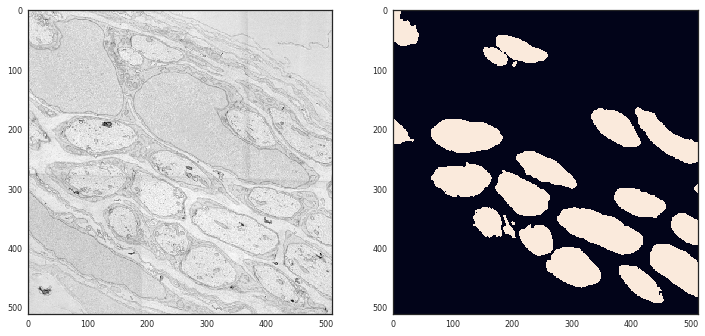

In [40]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(imgs[0],cmap='gray')
ax[1].imshow(masks[0])

In [41]:
apply_deform(imgs).shape

(10, 512, 512)

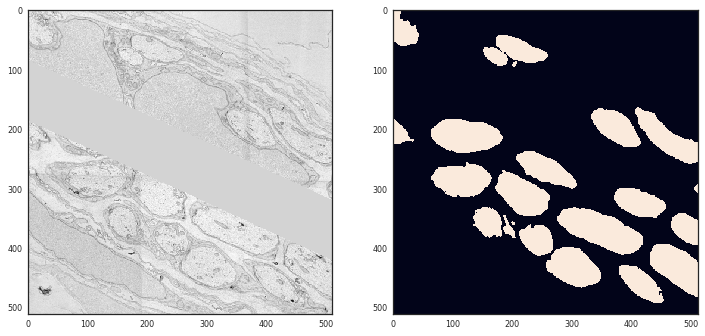

In [45]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(apply_deform(imgs)[0],cmap='gray')
ax[1].imshow(masks[0])

In [58]:
a,b = apply_elastic(imgs,masks)

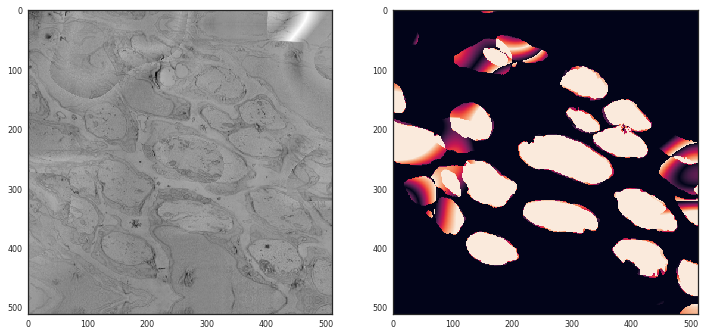

In [59]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(a[1],cmap='gray')
ax[1].imshow(b[1])

In [61]:
a,b =apply_elastic_transform(imgs,masks)

4


In [64]:
simpleaug_train_produce(imgs,masks)

TypeError: __init__() takes from 1 to 2 positional arguments but 3 were given

In [80]:
intensity = IntensityAugment(mode='mix', skip_ratio=0.5, CONTRAST_FACTOR=0.7, BRIGHTNESS_FACTOR=0.7)

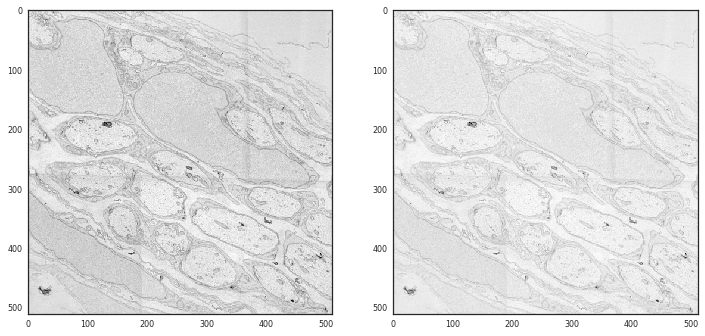

In [88]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(imgs[0],cmap='gray')
ax[1].imshow(intensity.augment(imgs)[0],cmap='gray')

In [75]:
imgs

array([[[0.6039216 , 0.58431375, 0.59607846, ..., 0.6784314 ,
         0.6666667 , 0.6666667 ],
        [0.7058824 , 0.6745098 , 0.59607846, ..., 0.6784314 ,
         0.6784314 , 0.6784314 ],
        [0.7137255 , 0.7019608 , 0.6901961 , ..., 0.69411767,
         0.6666667 , 0.6627451 ],
        ...,
        [0.6745098 , 0.6666667 , 0.6666667 , ..., 0.654902  ,
         0.67058825, 0.654902  ],
        [0.67058825, 0.67058825, 0.6745098 , ..., 0.654902  ,
         0.65882355, 0.64705884],
        [0.67058825, 0.6666667 , 0.68235296, ..., 0.654902  ,
         0.6745098 , 0.6627451 ]],

       [[0.62352943, 0.627451  , 0.6392157 , ..., 0.6431373 ,
         0.6431373 , 0.6392157 ],
        [0.5529412 , 0.5372549 , 0.5254902 , ..., 0.6431373 ,
         0.64705884, 0.64705884],
        [0.5647059 , 0.54509807, 0.5686275 , ..., 0.6392157 ,
         0.6313726 , 0.62352943],
        ...,
        [0.6509804 , 0.654902  , 0.6509804 , ..., 0.5686275 ,
         0.60784316, 0.6       ],
        [0.6

In [71]:
intensity.augment(imgs)[0]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [89]:
simpleaug = simpleaug_train_produce((4,512,512))

In [105]:
simpleaug =simpleaug_test_produce((4,512,512))

In [106]:
a = simpleaug(imgs)
b = simpleaug(masks)

In [107]:
b.shape

(16, 4, 512, 512)

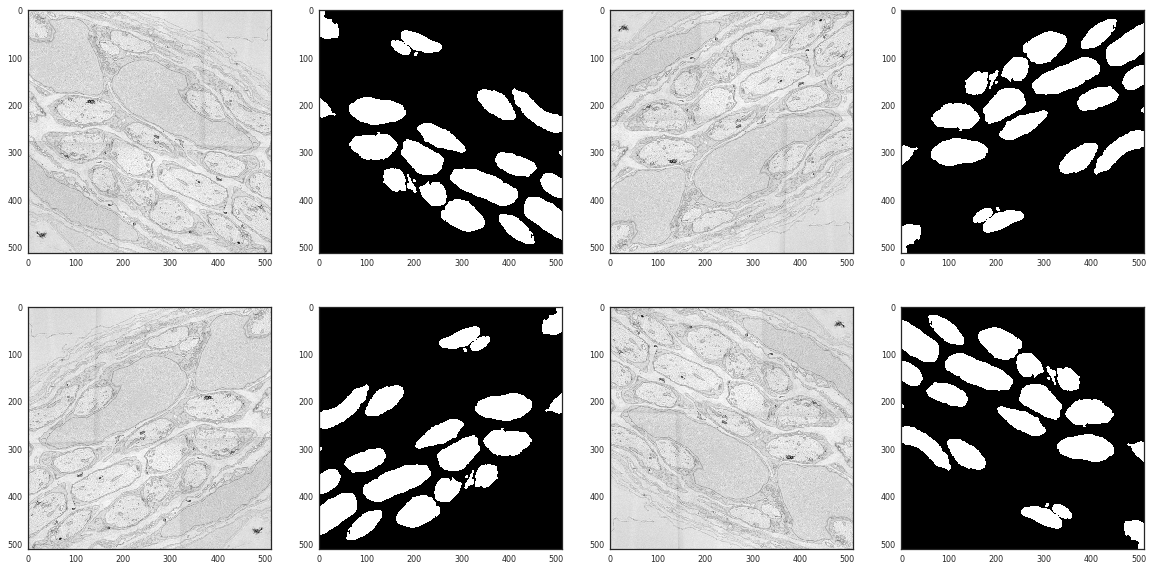

In [113]:
fig,ax=plt.subplots(2,4,figsize=(20,10))
for i in range(2):
    for j in range(4):
        if j%2==0:
            ax[i,j].imshow(a[4*i+j][0],cmap='gray')
        else:
            ax[i,j].imshow(b[4*i+j-1][0],cmap='gray')

In [19]:

import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from imageio import imread

Populating the interactive namespace from numpy and matplotlib


In [22]:
cd /home/xupeng/projects/membrane/

/home/xupeng/projects/membrane


In [23]:
import seaborn as sns
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_context(contexts[0])
sns.set_style(styles[0])

In [24]:
mask = imread('data/1.vsseg_export_s001.png')
mask[mask!=0] = 128
em = imread('data/KK_mask1_em_export_s001.png')

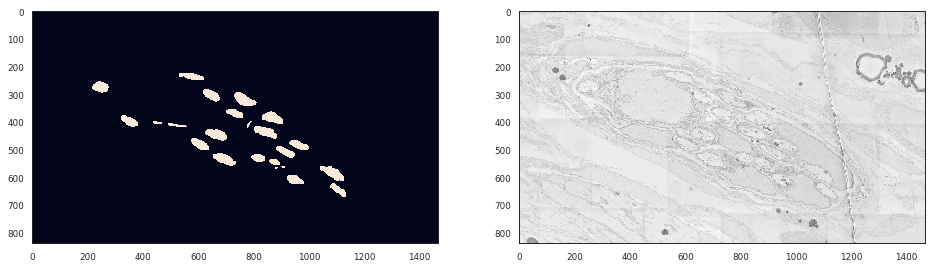

In [25]:
fig,ax=plt.subplots(1,2,figsize=(16,10))
ax[0].imshow(mask)
ax[1].imshow(em,cmap='gray')

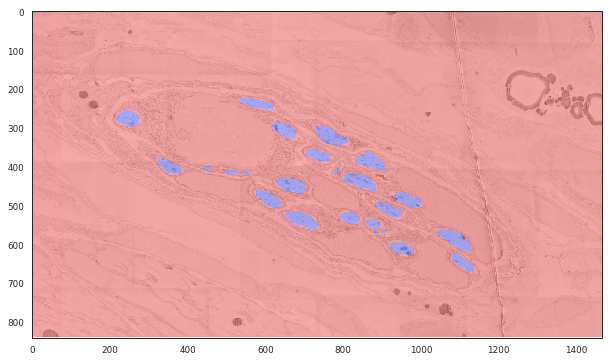

In [34]:
import skimage
fig,ax=plt.subplots(1,figsize=(16,6))
ax.imshow(skimage.color.label2rgb(mask,em),cmap=cm.coolwarm)

In [18]:
mask.shape,em.shape

((840, 1468, 3), (840, 1468, 3))